In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.interpolate import interp1d
import math
from pylanetary.navigation import *
from pylanetary.utils import *

# from uncertainties import ufloat # !!! this isn't in this kernel. need to install for spextrum file maker with https://stackoverflow.com/questions/41060382/using-pip-to-install-packages-to-anaconda-environment
'''from uncertainties.umath import *
from uncertainties import unumpy'''
from scipy import interpolate
from datetime import datetime
from datetime import timedelta
from astroquery.jplhorizons import Horizons
import astropy.units as u

import math
from scipy import ndimage

'''from pylanetary.navigation import *
from pylanetary.utils import Body
#from pylanetary.utils import I_over_F
from pylanetary.utils import *
import astropy.units as u
import math
from scipy import ndimage'''

'from pylanetary.navigation import *\nfrom pylanetary.utils import Body\n#from pylanetary.utils import I_over_F\nfrom pylanetary.utils import *\nimport astropy.units as u\nimport math\nfrom scipy import ndimage'

In [2]:
# functions used within map_maker().

def interceptellip(a,b,alpha,beta,gamma,x0,y0,z0):
    '''
    ; **********************************************************
    ; procedure to find the intercepts (if any) between the line
    ;
    ;  (x-x0)       (y-y0)      (z-z0)
    ;  ------  =    ------   =  ------
    ;  alpha         beta       gamma
    ; 
    ; and the ellipsoid
    ;
    ;
    ;  x^2    y^2    z^2   
    ;  --- +  --- +  ---  = 1
    ;  a^2    a^2    b^2
    ;
    ; Input variables
    ;       a       real    ellipsoid semi-major axis
    ;       b       real    ellipsoid semi-minor axis
    ;       alpha   real    line x-gradient
    ;       beta    real    line y-gradient
    ;       gamma   real    line z-gradient
    ;       x0      real    line x-intercept
    ;       y0      real    line y-intercept
    ;       z0      real    line z-intercept
    ;
    ; Output variables
    ;       iflag   integer Set to 1 if line intercepts, set to -1  otherwise
    ;       x(2)    real    x-intercepts
    ;       y(2)    real    y-intercepts
    ;       z(2)    real    z-intercepts
    ;
    ; Pat Irwin     11/2/07
    ; Python conversion - Emma Dahl 3-8-19
    ; **********************************************************
    '''
    a1 = 1.0/a**2 + (beta/(a*alpha))**2 + (gamma/(b*alpha))**2

    b1 = (-2*x0*beta**2/alpha**2 + 2*beta*y0/alpha)/a**2
    b1 = b1 + (-2*x0*gamma**2/alpha**2 + 2*gamma*z0/alpha)/b**2
    
    c1 = ((beta*x0/alpha)**2 - 2*beta*y0*x0/alpha + y0**2)/a**2
    c1 = c1 + ((gamma*x0/alpha)**2 - 2*gamma*x0*z0/alpha + z0**2)/b**2 -1
        
    #;print,a1,1.0/a**2 + (gamma/(b*alpha))**2
    #;print,b1,2*gamma*z0/(alpha*b**2)
    #;print,c1,(y0/a)**2 + (z0/b)**2 -1
    
    xtest = b1**2 - 4*a1*c1

    x = np.zeros(2)
    y = np.zeros(2)
    z = np.zeros(2)
        
    if xtest > 0.0:
        iflag = 1
        x[0] = (-b1 + np.sqrt(xtest))/(2*a1)
        x[1] = (-b1 - np.sqrt(xtest))/(2*a1)
        y[0] = y0 + (beta/alpha)*(x[0]-x0)
        y[1] = y0 + (beta/alpha)*(x[1]-x0)
        z[0] = z0 + (gamma/alpha)*(x[0]-x0)
        z[1] = z0 + (gamma/alpha)*(x[1]-x0)

        # testing to see if solution is on ellipsoid
        test=np.ndarray(len(x))
        for i in range(0,len(x)):
            test[i] = (x[i]/a)**2 + (y[i]/a)**2 + (z[i]/b)**2
        xtest1 = abs(test[0]-1.0)
        xtest2 = abs(test[1]-1.0)
        
        err = 1e-5
        
        if xtest1 > err or xtest2 > err:
            print('Problem in interceptellip - solution not on ellipsoid')
            print('Test =',test)
    else:
        iflag = -1


    return iflag,x,y,z

interceptellip_vec = np.vectorize(interceptellip)

def projposolar(Re,obl,epsilon,latsol,lonsol,se_lon,eoff,poff):
    '''
    ; ************************************************************
    ; Procedure to find latitude and longitude and zenith angle of
    ; intercept between line and ellipsoid
    ;
    ; Input variables
    ;       Re      real    Equatorial Radius (arcsec)
    ;       obl     real    Planetary oblateness
    ;       epsilon real    Sub-observer (planetocentric) latitude
    ;       latsol  real    Sub-solar planetocentric latitude
    ;       lonsol  real    longitude difference between sub-solar and sub-observer
    ;                       points.
    ;       se_lon  real    Sub-observer longitude # added by Emma
    ;       eoff    real    equatorial offset of beam (arcsec)
    ;       poff    real    polar offset of beam (arcsec)
    ;
    ; Output variables
    ;       iflag   integer Set to 1 if real intercept, -1 otherwise
    ;       xlat    real    Planetocentric latitude
    ;       longitude real  xlon+se_lon, offset of longitude added to sub-observer longitude # added by Emma
    ;       xlon    real    Longitude
    ;       zen     real    Zenith angle
    ;       szen    real    Solar zenith angle
    ;       aphi    real    local azimuth angle between sun and observer
    ;
    ; Pat Irwin     11/2/07
    ; Python conversion - Emma Dahl 3/8/19
    ; ************************************************************
    '''
    
    dtr = np.pi/180.0 # radians/degrees
    Rp = Re*(1.0-obl)
    
    x0 = 0.0
    y0 = eoff
    z0 = poff/np.cos(epsilon*dtr)
    
    alpha = np.sin(np.pi/2.0 - epsilon*dtr)
    beta = 0.0
    gamma = np.cos(np.pi/2.0 - epsilon*dtr)
    
    # commenting out to give program my own iflag map
    iflag,x,y,z = interceptellip_vec(Re,Rp,alpha,beta,gamma,x0,y0,z0)
    #print(iflag)
    
    xlat = 0.0
    xlon = 0.0
    zen = 0.0
    
    # !!! getting rid of iflag statement here because I already have the maps set up for real intercepts below
    #if iflag > 0:
    # if real intercept, find lat, long, and zenith

    # find distance along line of sight
    lambdaa = (x-x0)/alpha
    if lambdaa[0] > lambdaa[1]:
        inear = 0
    else:
        inear = 1

    x1 = x[inear]
    y1 = y[inear]
    z1 = z[inear]

    r = np.sqrt(x1**2 + y1**2 + z1**2)

    theta = np.arccos(z1/r)
    xlat = 90.0 - theta/dtr

    #; convert to planetographic latitude
    #; xlat = np.arctan(((Re/Rp)**2)*np.tan(xlat*dtr))/dtr

    cphi = x1/(r*np.sin(theta))

    if cphi > 1.0:
        cphi = 1.0
    if cphi < -1.0:
        cphi = -1.0

    phi = np.arccos(cphi)
    if y1 < 0.0:
        phi = -phi
    xlon = phi/dtr        

    # Finding aphi, zen, szen - don't mess with these, want to still output them

    v1 = np.zeros(3)
    v2 = np.zeros(3)
    v3 = np.zeros(3)

    # v1 is normal vector of point observed
    v1[0] = x1/r
    v1[1] = y1/r
    v1[2] = z1/r

    v2[0] = alpha
    v2[1] = beta
    v2[2] = gamma

    summ = 0.0

    for i in range(0,3):
        summ += v1[i]*v2[i]
    zen = np.arccos(summ)/dtr

    # Finding aphi

    alphasol = np.sin(np.pi/2.0 - latsol*dtr)*np.cos(lonsol*dtr)
    betasol =  np.sin(np.pi/2.0 - latsol*dtr)*np.sin(lonsol*dtr)
    gammasol = np.cos(np.pi/2 - latsol*dtr)
    v3[0]=alphasol
    v3[1]=betasol
    v3[2]=gammasol

    summ = 0.0
    for i in range(0,3):
        summ += v1[i]*v3[i]
    szen = np.arccos(summ)/dtr

    cphase = 0.0

    for i in range(0,3):
        cphase += v2[i]*v3[i]

    a = np.cos(zen*dtr)*np.cos(szen*dtr)
    b = np.sin(zen*dtr)*np.sin(szen*dtr)

    if b == 0.0:
        aphi = 180.0
    else:
        cphi = (cphase-a)/b
        aphi = 180.0-np.arccos(cphi)/dtr
            
    longitude = se_lon-xlon # offset of longitude added to sub-observer longitude
    # Remember that system III longitude increases to the west
    
    #return xlat,longitude
    return iflag,xlat,longitude,xlon,zen,szen,aphi
    #return xlat,longitude,xlon,zen,szen,aphi

projposolar_vec = np.vectorize(projposolar)

In [6]:
def map_maker(filename, plot_maps=0,  ut_date='DATE_OBS', ut_time='TIME_OBS', target='OBJECT', location_code='568', pixelscale=0.115696):
    
    '''
    # !!! write good docstring here
    '''
    
    print('Loading image info and querying Horizons...')
    
    #tuples of planets and their Horizons codes. Only gas giants for now, can add terrestrial planets. Horizons code, name, equatorial radius (km), polar radius (km), oblateness. would be nice to be able to pull radii from horizons eventually
    planets = ('599','Jupiter',71492,66854,0.06487),('699','Saturn',60268,54364,0.09796),('799','Uranus',25559,24973,0.0229),('899','Neptune',24766,24342,0.0171)
    
    # first, use ModelEllipsoid to generate maps for a given image. Need to get sub-obs lon and lat, pixel scale, north polar angle, equatorial radius and polar radius from Horizons by pulling info from header.

    # import image
    im = fits.open(filename)
    header = im[0].header
    data = im[0].data
    if plot_maps == 1:
        plt.imshow(data,origin='lower')
        plt.title('original data')
        plt.show()


    # based on UT time/date and location of observations, query Horizons for viewing geom info
    UT_date = header[ut_date] 
    UT_time = header[ut_time]
    target = 'Jupiter' # header[target] # observed planet. !!! hard-coded. maybe just put this as planet as optional input

    # Account for fractional seconds in UT_time if it exists. datetime does not like fractional seconds.
    if '.' in UT_time:
        nofrag, frag = UT_time.split('.')
        UT_time = nofrag    

    # Query horizons. !! The date/time format for UT_date and UT_time as used in date_obj are specific to the format used by the IRTF.

    for k in planets: # find planet code, r_eq, r_pol, obl
        if k[1] == target: # assumes target string is exactly correct. might be an issue if there are additional spaces
            id_number = k[0]; planet_label = k[1]; req = k[2]; rpol = k[3]; obl = k[4]

    # calculate julian date
    date_obj = datetime.strptime(UT_date+' '+UT_time, '%Y-%m-%d %H:%M:%S') # define datetime object based on UT date and time. Might have issue bc seconds are fractional
    date_only_obj = datetime.strptime(UT_date, '%Y-%m-%d')
    h = int(date_obj.strftime("%H"))
    m = int(date_obj.strftime("%M"))
    s = int(date_obj.strftime("%S"))
    dt = timedelta(hours=h, minutes=m, seconds=s)
    secs_per_day = 24*60*60    # hours * mins * secs
    jd_time_fraction = dt.total_seconds()/secs_per_day # fraction of day time, to add to date

    jd = date_only_obj.toordinal() + 1721424.5 + jd_time_fraction # based on https://stackoverflow.com/questions/13943062/extract-day-of-year-and-julian-day-from-a-string-date

    # define horizons query
    obj = Horizons(id=id_number, location=location_code, epochs=jd)

    # put ephimerides into a table
    table = obj.ephemerides()
    distance_au = table['delta'][0]
    distance = table['delta'][0]*1.496E8 # in AU, convert to km

    # define values needed for ModelEllopsoid
    ob_lon = table['PDObsLon'][0] #sub-observer longitude, degrees
    ob_lat = table['PDObsLat'][0] #sub-observer latitude, degrees, planetocentric
    sol_lon = table['PDSunLon'][0] #sub-solar longitude, degrees
    sol_lat = table['PDSunLat'][0] #sub-solar latitude, degrees, planetocentric
    pixscale_km = np.arctan(pixelscale*(1/206265))*distance
    np_ang = table['NPole_ang'][0] #degrees 

    # save values of values needed for projposolar, outside of eoff and poff. gratiutous but I'm tired
    Re = (req/pixscale_km)*pixelscale # equatorial radius in arcsec
    epsilon = ob_lat # Sub-observer (planetographic) latitude
    latsol = sol_lat # Sub-solar planetocentric latitude
    lonsol = sol_lon-ob_lon # longitude difference between sub-solar and sub-observer points

    # define offset and rotation values to be used for both data and iflag map rotation
    # !! hard coded planet center value keywords for IRTF
    cx = im[0].header['cx']; cy = im[0].header['cy']
    # x and y center of image
    x1 = im[0].header['naxis1']/2; y1 = im[0].header['naxis2']/2
    x_offset = int(cx-x1); y_offset = int(cy-y1)
    rot_ang = np.copy(np_ang)

    # - - - - - - - - - - - - - - - - - - - - - - 
    # generate iflag map using nav, rotate and crop

    # use pylanetary just to generate map of where planet is and isn't, Might not need all lines here but keeping anyways to make sure nothing breaks
    obs_time = UT_date + ' ' + UT_time
    ellipsoid = ModelEllipsoid(ob_lon, ob_lat, pixscale_km, np_ang, req, rpol)
    body = Body(target, epoch=obs_time, location=location_code) 
    model = ModelBody(body, pixelscale, shape=(len(data),len(data[0])))
    nav = Nav(data, body, pixelscale)

    #diagnostic
    #plt.imshow(nav.lat_g)
    #plt.title('latitude, unrotated and uncentered and uncropped')
    #plt.show()

    # use nav to make iflag map
    rotated_lat_map = np.copy(nav.mu)
    rotated_lat_map[np.where(np.isnan(rotated_lat_map)==True)] = 0
    # don't need to center since nav does that already
    #rotated_lat_map=np.roll(rotated_lat_map,-y_offset,axis=0)
    #rotated_lat_map=np.roll(rotated_lat_map,-x_offset,axis=1)
    #diagnostic plot
    #plt.imshow(rotated_lat_map)
    #plt.title('latitude, centered')
    #plt.show()

    # rotate
    rotated_lat_map = ndimage.rotate(rotated_lat_map,rot_ang)
    #diagnostic
    #plt.imshow(rotated_lat_map)
    #plt.title('latitude, centered and rotated')
    #plt.show()

    # crop; ! might want to just use the same crop values for both data and iflag centeirng?
    if len(rotated_lat_map) > header['naxis1'] or len(rotated_lat_map[0]) > header['naxis2']:
        x_crop = int((len(rotated_lat_map)-header['naxis1'])/2)
        y_crop = int((len(rotated_lat_map[0])-header['naxis2'])/2)
        rotated_lat_map = rotated_lat_map[x_crop:-x_crop,y_crop:-y_crop]

    #diagnostic
    #plt.imshow(rotated_lat_map)
    #plt.title('latitude, centered cropped and rotated')
    #plt.show()

    # - - - - - - - - - - - - - - - - - - - - - - 
    # rotate and crop data after it's been used to orient the iflag map
    # rotate and center image 
    data=np.roll(data,-y_offset,axis=0)
    data=np.roll(data,-x_offset,axis=1)

    data = ndimage.rotate(data,np_ang)

    # crop centered and rotated data
    if len(data) > header['naxis1'] or len(data[0]) > header['naxis2']:
        x_crop = int((len(data)-header['naxis1'])/2)
        y_crop = int((len(data[0])-header['naxis2'])/2)
        data = data[x_crop:-x_crop,y_crop:-y_crop]
    np_ang_orig = np.copy(np_ang)
    np_ang = 0
    x_offset = 0; y_offset = 0

    if plot_maps == 1:
        plt.imshow(data,origin='lower')
        plt.title('centered rotated and cropped data')
        plt.show()

    # !!! change rotated_lat_map to be iflag variable name
    # make sure iflag map and data have the same dimensions (otherwise will have issues mapping arrays later)
    if len(data) != len(rotated_lat_map) or len(data[0]) != len(rotated_lat_map[0]):
        print('! size of iflag map and data are not equal !')
        print('len(data):',len(data),'rotated_lat_map:',len(rotated_lat_map))
        print('len(data[0]):',len(data[0]),'rotated_lat_map[0]:',len(rotated_lat_map[0]))

    # use the rotated latitude map to generate the correct eoff and poff arrays
    # since using nd image rotate on 0's, very close to 0, rounding down. !!! very janky. 
    iflag_map = np.copy(rotated_lat_map)
    iflag_map = np.round(iflag_map,1)
    iflag_map[np.where(iflag_map==0)] = 0
    iflag_map[np.where(iflag_map!=0)] = 1

    # - - - - - - - - - - - - - - - - - - - - -
    # find eoff and poff, equatorial and polar offset needed for projposolar.

    # finding center point based on data array (should be same as x1 and y1 earlier?)
    x_center = len(data)/2
    y_center = len(data[0])/2

    # don't need but might be helpful for testing
    unrot_x = np.where(iflag_map==1)[0]
    unrot_y = np.where(iflag_map==1)[1]

    # list of coordinates where the planet is. Shifted to have origin at middle of image/planet
    x = unrot_x-x_center
    y = unrot_y-y_center

    np_ang_radians = np_ang*0.0174533 # rad/deg # in case still need to rotate. should be 0 if data already rotated

    # flipped these bc lat and long maps where backwards
    eoff = -x*np.sin(np_ang_radians)+y*np.cos(np_ang_radians)
    poff = x*np.cos(np_ang_radians)+y*np.sin(np_ang_radians)
    
    # eoff and poff correspond to locations in np.where(np.isnan(nav.mu)==False), so zen etc. should be assigned to those locations. If a pixel location listed in np.where(np.isnan(nav.mu)==False) is not assigned a zen value, interpolate between adjacent zen values.

    # translate the pixel offsets to arcsec offsets    
    eoff*=pixelscale 
    poff*=pixelscale

    # map eoff and poff values onto planet pixel locations using iflag
    eoff_final = np.copy(iflag_map)
    poff_final = np.copy(iflag_map)

    eoff_final[np.where(iflag_map==1)] = eoff
    poff_final[np.where(iflag_map==1)] = poff

    eoff_final[np.where(iflag_map!=1)] = np.nan
    poff_final[np.where(iflag_map!=1)] = np.nan

    if plot_maps == 1: # commented out bc not really necessary. Helpful for assessing issues though
        plt.imshow(eoff_final,origin='lower')
        plt.title('equatorial offset in arcsec')
        plt.colorbar()
        plt.show()
        plt.imshow(poff_final,origin='lower')
        plt.colorbar()
        plt.title('polar offset in arcsec')
        plt.show()

    # run projposolar, usng iflag map to find location of planet pixels
    print('Generating maps...(ignore following errors, they are accounted for w/ iflag map)')

    # will get mad if passed nans
    # generate maps of all the following values:
    iflag,latitude_final,longitude_final,xlon,zen,szen,aphi = projposolar_vec(Re,obl,epsilon,latsol,lonsol,ob_lon,eoff_final,poff_final)

    # flip maps along vertical axis (probably more elegant way to do this)
    szen=np.flip(szen,axis=1)
    aphi=np.flip(aphi,axis=1)
    
    if plot_maps == 1:
        plt.imshow(latitude_final,origin='lower')
        plt.colorbar(label='Latitude')
        plt.show()
        
        plt.imshow(longitude_final,origin='lower')
        plt.colorbar(label='Longitude (Sys III)')
        plt.show()
        
        plt.imshow(zen,origin='lower')
        plt.colorbar(label='Zenith emission angle')
        plt.show()
        
        plt.imshow(szen,origin='lower')
        plt.colorbar(label='Solar zenith angle')
        plt.show()
        
        plt.imshow(aphi,origin='lower')
        plt.colorbar(label='Azimuth angle')
        plt.show()

    return iflag,latitude_final,longitude_final,xlon,zen,szen,aphi,data,ob_lon,distance_au

Loading image info and querying Horizons...


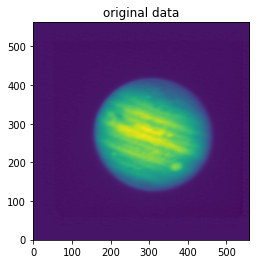

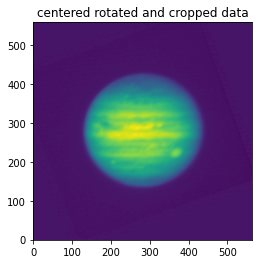

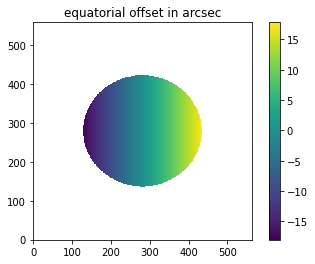

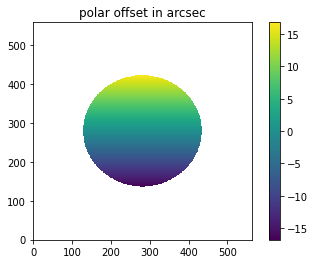

Generating maps...(ignore following errors, they are accounted for w/ iflag map)


/Users/emmadahl/opt/anaconda3/envs/pylanetary-tester/lib/python3.9/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in interceptellip (vectorized)
  outputs = ufunc(*inputs)
/var/folders/6_/b5j8td9x1658s508536j31jr0000gq/T/ipykernel_91752/745263981.py:153: RuntimeWarning: invalid value encountered in scalar divide
  theta = np.arccos(z1/r)
/var/folders/6_/b5j8td9x1658s508536j31jr0000gq/T/ipykernel_91752/745263981.py:178: RuntimeWarning: invalid value encountered in scalar divide
  v1[0] = x1/r
/var/folders/6_/b5j8td9x1658s508536j31jr0000gq/T/ipykernel_91752/745263981.py:179: RuntimeWarning: invalid value encountered in scalar divide
  v1[1] = y1/r
/var/folders/6_/b5j8td9x1658s508536j31jr0000gq/T/ipykernel_91752/745263981.py:180: RuntimeWarning: invalid value encountered in scalar divide
  v1[2] = z1/r


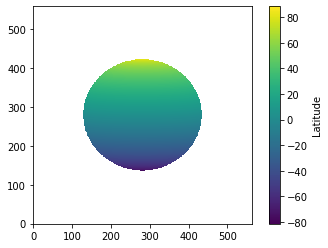

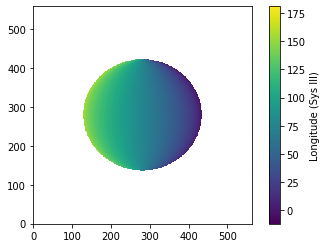

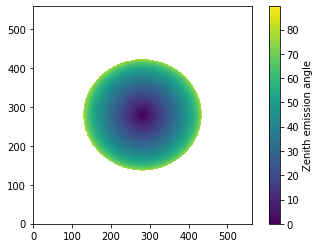

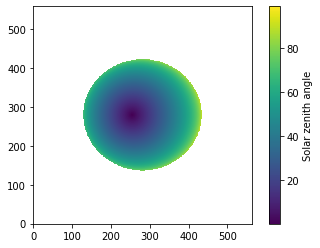

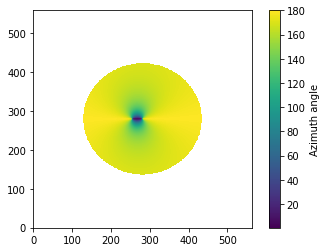

In [7]:
# test:
iflag,latitude_final,longitude_final,xlon,zen,szen,aphi,data,lcm,distance_au = map_maker('/Users/emmadahl/Desktop/spextraction/test_data/jupiter/jcf01170125.gz.fits',plot_maps=1)

In [8]:
def spex_wavelengths(filename):
    '''
    Routine to find the correct wavelength for a SpeX Guidedog image given certain OS filter and G filter combos.
    wavelength: midpoint originally from table at http://irtfweb.ifa.hawaii.edu/~spex/work/filters/filters.html (but link seems to be broken now)
    
    input
    -filename: string, path+name of fits file to read. presumption is that this is a guidedog image.
    
    output
    -Wavelength float. mircons
    will return error if no matching wavelength is found
    '''
    wavelength = -1
    
    im = fits.open(filename)
    header = im[0].header
    osfilt = header['OSF']
    gfilt = header['GFLT']
    
    if gfilt == 'Open':
        # define list of tuples
        wavelength_tuple = (('Open',0.00),('Blank',0.00),('PK-50',2.5), ('Opt',2.5),  ('0.1',0.1), ('Long4',5.2), ('Long5',3.86), ('Long6',3.33), ('Short3',2.22), ('Short4',1.63), ('Short5',1.27), ('Short6',1.15), ('Short7',.95), ('CH4_l' ,1.69), ('CH4_s',1.58))
        for j in wavelength_tuple:
            if j[0] == osfilt:
                wavelength = j[1]
                return wavelength
        
    elif gfilt == 'H' and osfilt == 'CH4_s':
        wavelength = 1.58
        return wavelength
    elif gfilt == 'H' and osfilt == 'CH4_l':
        wavelength = 1.69
        return wavelength
        
    else:
        # define list of tuples
        wavelength_tuple = (('Open',0.00), ('Blank',0.00), ('Z',1.00),('J',1.215), ('H',1.654), ('K',2.23), ("L'",3.80), ('Lp',3.80), ("M'",4.76) ,('FeII',1.64), ('H2',2.12), ('Bry',2.16), ('contK',2.26), ('CO',2.29), ("M'+ND1",4.76), ('3.417',3.417), ('3.454',3.454), ('5.1',5.100))
        for j in wavelength_tuple:
            if j[0] == gfilt:
                wavelength = j[1]
                return wavelength
        
    if wavelength == -1:
        print('Error! No matching wavelength found for filter combo by spex_wavelengths()')
        return

In [9]:
def map_saver(dictionary,key,map_save_location,wl):
    '''
    just saves the map of mapvalue (e.g. aphi, zen, etc.) to a file. Making this a routine to avoid copying the same 3 lines over and over    
    '''
    '''
    np.savetxt version:
    dictionary: wavelength dictionary of map dictionaries
    key = string, label of map, will be used as key to pull that array
    map_save_location = string, path of location to save maps
    wl = wavelength of dictionary of dictionaries
    '''
    wl = str(wl)
    wl_dict = dictionary[wl]
    np.savetxt(map_save_location+key+'_'+str(wl),wl_dict[key+'_'+str(wl)])

In [ ]:
'''def distance_finder():
    !! emma needs to write this'''

In [13]:
def spextraction_images(format_file, data_list, wavelength_keyword='OSF',plot_maps=0,map_save=0,map_load=0,map_save_location='/Users/emmadahl/Desktop/spextraction/test_maps/'):
    # !!! change map_save_location
    '''    
    Extract spectra based on user input, using maps generated by map_maker(). This version is for extracting spectra from images. Maybe make other versions later?
    
    Input:
    format_file - string, path+name of input file. contains code for what kind of spectra to make (1=equal mu bins within a given latitude/longitude bin). For now, only 1 format but will change that.
    data_list - input file containing paths+names of images to extract spectra from. Proabbly just want one image per wavelength and grouped together in time (up to the user how to do that). Will sort by wavelength here so no need to do that in the input file. Will assume that the list contains images of the same target. 
    plot_maps - on/off switch, int. Will plot maps
    
    saving/loading things: take advantage of this! otherwise takes a while to make maps new every time.
    map_save - int, on/off switch. 1, will save maps to path defined by map_save_location. 0, won't.
    load_maps - int, on/off switch. 1, will load maps from path defined by map_save_location. 0, won't.
    map_save_location - path to location of saved maps. Make this default the place on your computer where you want to save maps
    
    output:
    arrays for each image/wavelength
    
    # !! lots of comments with !! need attention. didn't bother to write htem here as to-do items
    but lcm is acting real weird. since we're doing meridian
    '''
    
    datalist = np.loadtxt(data_list,dtype=str) # load list of images
    guidedog_wavelengths = () # list of tuples that correspond to the filters used and corresponding wavelengths. OSF, GFLT, and then WL # !! might not use this
    
    # sort images by wavelength
    wl = []
    image = []
    if wavelength_keyword == 'OSF': # if spex guidedog images
        for j in datalist:
            wl.append(spex_wavelengths(j))
            image.append(j)
    else:
        for j in datalist:
            im = fits.open(j)
            wl.append(im[0].header[wavelength_keyword])
            image.append(j)
    # sort images based on wavelength
    wl_sorted_images = [x for _,x in sorted(zip(wl,image))]
    wavelengths_sorted = sorted(wl)
    
    print(wavelengths_sorted)
    
    # open input file and determine type of spectrum to make
    with open(format_file,'r') as f:
        all_data=[x.split() for x in f.readlines()]
        spec_type = int(all_data[0][0]) # find and define
        if spec_type == 1:
            # if mu-binned lat spectrum, find other requirements:
            lat_min = float(all_data[1][0])
            lat_max = float(all_data[1][1])
            mu_min = float(all_data[2][0])
            n_bins = int(all_data[3][0])
            meridian_switch = float(all_data[4][0])
            w_mu = float(all_data[5][0])
            
        elif spec_type == 2:
            # if different kind of spectrum, do something else. Fill this in later.
            return
            
    
    # - - - - - - - - - - - Map saving/loading
    
    # make maps for each image/wavelength. Is there a way to write this avoid making new maps every time? save them somewhere with the obs_time in the file name, and we can check to see if it's been saved somewhere already.
    map_dict = {}
    for i in range(0,len(wl_sorted_images)):
        print('Arranging map info for',str(wavelengths_sorted[i]))
        if map_load == 1:
            map_dict_dummy = {}
            # load each map for that wavelength and save it to the dictionary
            iflag = np.loadtxt(map_save_location+'iflag_'+str(wavelengths_sorted[i]))
            latitude_final = np.loadtxt(map_save_location+'latitude_final_'+str(wavelengths_sorted[i]))
            longitude_final = np.loadtxt(map_save_location+'longitude_final_'+str(wavelengths_sorted[i]))
            zen = np.loadtxt(map_save_location+'zen_'+str(wavelengths_sorted[i]))
            szen = np.loadtxt(map_save_location+'szen_'+str(wavelengths_sorted[i]))
            aphi = np.loadtxt(map_save_location+'aphi_'+str(wavelengths_sorted[i]))
            mu = np.loadtxt(map_save_location+'mu_'+str(wavelengths_sorted[i]))
            data = np.loadtxt(map_save_location+'data_'+str(wavelengths_sorted[i]))
            lcm = np.loadtxt(map_save_location+'lcm_'+str(wavelengths_sorted[i]))
            
            map_dict_dummy['iflag_'+str(wavelengths_sorted[i])] = iflag
            map_dict_dummy['latitude_final_'+str(wavelengths_sorted[i])] = latitude_final
            map_dict_dummy['longitude_final_'+str(wavelengths_sorted[i])] = longitude_final 
            map_dict_dummy['zen_'+str(wavelengths_sorted[i])] = zen 
            map_dict_dummy['szen_'+str(wavelengths_sorted[i])] = szen
            map_dict_dummy['aphi_'+str(wavelengths_sorted[i])] = aphi
            map_dict_dummy['mu_'+str(wavelengths_sorted[i])] = mu
            map_dict_dummy['data_'+str(wavelengths_sorted[i])] = data
            map_dict_dummy['lcm_'+str(wavelengths_sorted[i])] = lcm
            map_dict[str(wavelengths_sorted[i])] = map_dict_dummy
            
        else: # otherwise, make a dictionary of maps for that wavelength
            map_dict_dummy = {}
            iflag,latitude_final,longitude_final,xlon,zen,szen,aphi,data,lcm,distance_au = map_maker(wl_sorted_images[i],plot_maps)
                        
            map_dict_dummy['iflag_'+str(wavelengths_sorted[i])] = iflag
            map_dict_dummy['latitude_final_'+str(wavelengths_sorted[i])] = latitude_final
            map_dict_dummy['longitude_final_'+str(wavelengths_sorted[i])] = longitude_final 
            map_dict_dummy['zen_'+str(wavelengths_sorted[i])] = zen 
            map_dict_dummy['szen_'+str(wavelengths_sorted[i])] = szen
            map_dict_dummy['aphi_'+str(wavelengths_sorted[i])] = aphi
            map_dict_dummy['mu_'+str(wavelengths_sorted[i])] = np.cos(zen*0.0174533)
            map_dict_dummy['data_'+str(wavelengths_sorted[i])] = data
            # code is getting mad that lcm isn't an array. i'm tired so here is the bad fix
            lcm_array = np.copy(data)
            lcm_array[:,:] = lcm
            map_dict_dummy['lcm_'+str(wavelengths_sorted[i])] = lcm_array
            map_dict[str(wavelengths_sorted[i])] = map_dict_dummy            
            
            # option to save maps
            if map_save == 1:
                print('Saving maps at '+str(wavelengths_sorted[i])+'...')
                map_saver(map_dict,'iflag',map_save_location,wavelengths_sorted[i])
                map_saver(map_dict,'latitude_final',map_save_location,wavelengths_sorted[i])
                map_saver(map_dict,'longitude_final',map_save_location,wavelengths_sorted[i])
                map_saver(map_dict,'zen',map_save_location,wavelengths_sorted[i])
                map_saver(map_dict,'szen',map_save_location,wavelengths_sorted[i])
                map_saver(map_dict,'aphi',map_save_location,wavelengths_sorted[i])
                map_saver(map_dict,'mu',map_save_location,wavelengths_sorted[i])
                map_saver(map_dict,'data',map_save_location,wavelengths_sorted[i])
                map_saver(map_dict,'lcm',map_save_location,wavelengths_sorted[i])
                # if normal file.write() stuff works in map_saver: map_saver(iflag,map_save_location,wavelengths_sorted[i])
                          
            else:
                continue
    
    # - - - - - - - - - - - - - - - - - - - - - 
    
    # find mu_max from an example map. !! might need to do this for each wavelength?? might be fine
    wl_dummy = wavelengths_sorted[0]
    mu_map = map_dict[str(wl_dummy)]['mu_'+str(wl_dummy)]
    lat_map = map_dict[str(wl_dummy)]['latitude_'+str(wl_dummy)]
    data_map = map_dict[str(wl_dummy)]['data_1.64'+str(wl_dummy)]

    coordinates = np.where((lat_map<lat_max) & (lat_map>lat_min)) 

    mu_max = np.max(mu_map[coordinates])

    new=np.copy(mu_map); data_test = np.copy(data_map); data_test2 = np.copy(data_map)

    new[coordinates] = 5000
    new_coordinates = np.where(new<5000) # !! don't use new here

    data_test[coordinates] = np.nan # blank out data we're sampling
    data_test2[new_coordinates] = np.nan # show only data we're sampling

    if plot_maps == 1:
        print('Region of spectral extraction:')
        plt.imshow(new,origin='lower')
        plt.show()
        plt.imshow(data_test,origin='lower')
        plt.show()
        plt.imshow(data_test2,origin='lower')
        plt.show()
        
    # - - - - - - - - - - - - - - - - - - - - -
    
    # based on inputs above, extract spectra from maps
    
    n_wavel = len(wavelengths_sorted) # number of wavelengths
    wavel_spxs = np.copy(wavelengths_sorted) # just copying this instead of renaming bc lazy

    # define bins based on n_mu (number of bins) and other info calculated earlier
    if spec_type == 1:
        d_mu = ((mu_max-mu_min)/n_bins) # size of mu bin
        print('Size of mu bin:',d_mu)
    else:
        continue # add other spectral types here

    # define bins w/ the size of bin (d_mu) in mu-space. not relevant yet
    #d_mu = 0.1 # example, if defining by size of bin
    '''
    mu_max = 1.0
    w_mu = 0.1
    n_mu = int((mu_max-mu_min)/d_mu)
    n_bins = n_mu*2+1
    '''
    
    # utilize dictionaries to save spectra and corresponding geometry values for each wavelength.
    
    # make empty arrays for binning section. columns = bins, rows = wavelengths
    extracted_spectrum_ave = np.zeros((n_bins,n_wavel))
    extracted_lat_ave = np.zeros((n_bins,n_wavel))
    extracted_long_ave = np.zeros((n_bins,n_wavel))
    extracted_emiss_ave = np.zeros((n_bins,n_wavel))
    extracted_solar_ave = np.zeros((n_bins,n_wavel))
    extracted_azi_ave = np.zeros((n_bins,n_wavel))

    for i_wavel in range(0,len(wavel_spxs)):
        
        print('Extracting spectra for',wavel_spxs[i_wavel],'nm...')
        
        # pull maps for this wavelength
        # !!! just raw data here for spxs. need conversion factor or something
        spxs = map_dict[str(wavel_spxs[i_wavel])]['data_'+str(wavel_spxs[i_wavel])]
        mu_spxs = map_dict[str(wavel_spxs[i_wavel])]['mu_'+str(wavel_spxs[i_wavel])]
        lat_spxs = map_dict[str(wavel_spxs[i_wavel])]['latitude_final_'+str(wavel_spxs[i_wavel])]
        long_spxs = map_dict[str(wavel_spxs[i_wavel])]['longitude_final_'+str(wavel_spxs[i_wavel])]
        solar_spxs = map_dict[str(wavel_spxs[i_wavel])]['szen_'+str(wavel_spxs[i_wavel])]
        zen_spxs = map_dict[str(wavel_spxs[i_wavel])]['zen_'+str(wavel_spxs[i_wavel])]
        azimuth_spxs = map_dict[str(wavel_spxs[i_wavel])]['aphi_'+str(wavel_spxs[i_wavel])]
        lcm_spxs = map_dict[str(wavel_spxs[i_wavel])]['lcm_'+str(wavel_spxs[i_wavel])] 

        # once lists are loaded, extract spectra
        wavel = wavel_spxs[i_wavel]

        # h = 0 # bin index, for assigning values in arrays. might need if meridian_switch = 0
        
        for i_mu in range(0,n_bins):
            # calculate mu boundaries
            # !! this is giving mu values above 1 which don't exist
            mu_0 = mu_min + float(d_mu*i_mu)
            mu_1 = mu_min + float(d_mu*i_mu) + w_mu
            print('mu_0=',mu_0,'mu_1=',mu_1)

            if meridian_switch == 1: # if averaging bins on either side of meridian

                coords = np.where((lat_map<lat_max) & (lat_map>lat_min) & (mu_map>mu_0) & (mu_map<mu_1))
                if plot_maps == 1:
                    spxs_test = np.copy(spxs)
                    spxs_test[coords] = np.nan
                    plt.imshow(spxs_test,origin='lower')
                    plt.title('extraction region for bin '+str(i_mu))
                    plt.show()
                    
                # save average of the regions within coords to extracted_* arrays
                extracted_spectrum_ave[i_mu,i_wavel] = np.mean(spxs[coords])
                extracted_lat_ave[i_mu,i_wavel] = np.mean(lat_spxs[coords])
                extracted_long_ave[i_mu,i_wavel] = np.mean(long_spxs[coords])
                extracted_emiss_ave[i_mu,i_wavel] = np.mean(zen_spxs[coords])
                extracted_solar_ave[i_mu,i_wavel] = np.mean(solar_spxs[coords])
                extracted_azi_ave[i_mu,i_wavel] = np.mean(azimuth_spxs[coords])
                
            elif meridian_switch == 0:
                print('Emma hasnt coded this yet, do not use')
                # here's where lcm would be used. eg as condition for either side of lcm
                return 
 
    # add distance-finding routine here. make array w number of bins to assign distances to
    # !!!! update mu_max to stay below 1.
    
    return extracted_spectrum_ave, extracted_lat_ave, extracted_long_ave, extracted_emiss_ave, extracted_solar_ave, extracted_azi_ave, wavelengths_sorted, distance_au, n_bins

[1.64, 1.69, 2.16]
Arranging map info for 1.64
Arranging map info for 1.69
Arranging map info for 2.16
Region of spectral extraction:


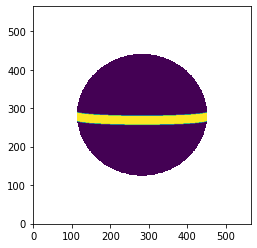

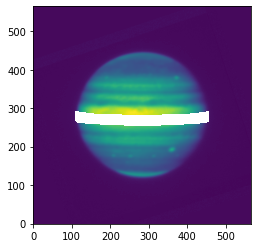

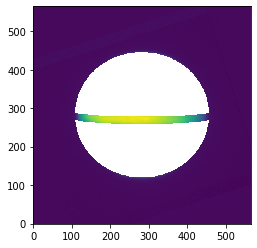

Size of mu bin: 0.06248618085585278
Extracting spectra for 1.64 nm...
mu_0= 0.5 mu_1= 0.8


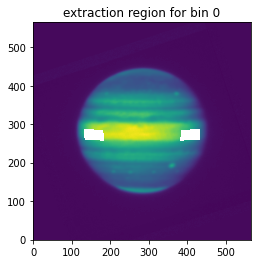

mu_0= 0.5624861808558528 mu_1= 0.8624861808558528


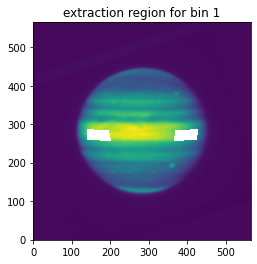

mu_0= 0.6249723617117056 mu_1= 0.9249723617117056


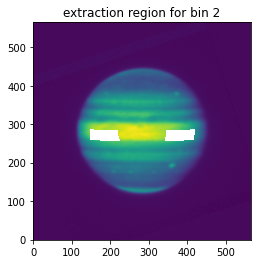

mu_0= 0.6874585425675583 mu_1= 0.9874585425675584


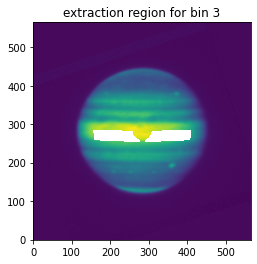

mu_0= 0.7499447234234111 mu_1= 1.0499447234234112


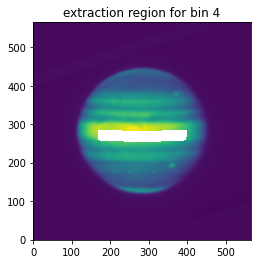

mu_0= 0.8124309042792639 mu_1= 1.112430904279264


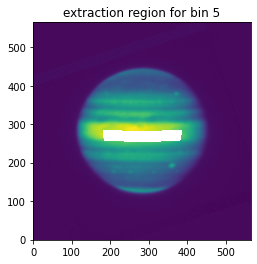

mu_0= 0.8749170851351167 mu_1= 1.1749170851351167


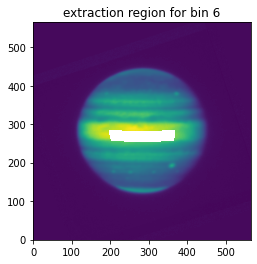

mu_0= 0.9374032659909695 mu_1= 1.2374032659909695


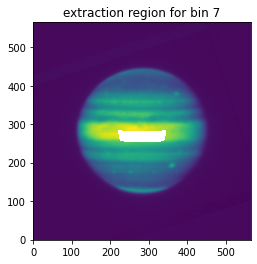

Extracting spectra for 1.69 nm...
mu_0= 0.5 mu_1= 0.8


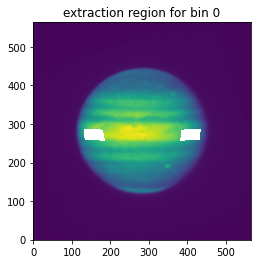

mu_0= 0.5624861808558528 mu_1= 0.8624861808558528


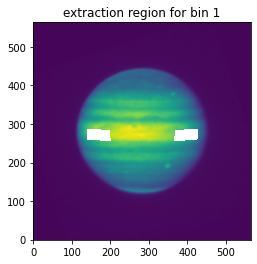

mu_0= 0.6249723617117056 mu_1= 0.9249723617117056


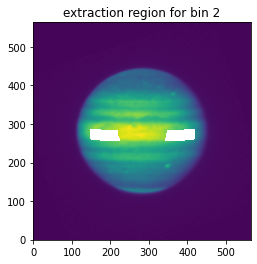

mu_0= 0.6874585425675583 mu_1= 0.9874585425675584


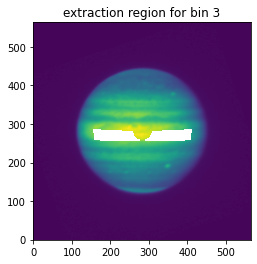

mu_0= 0.7499447234234111 mu_1= 1.0499447234234112


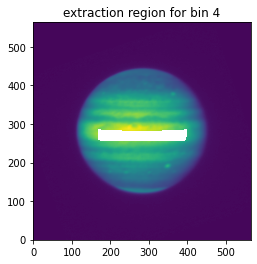

mu_0= 0.8124309042792639 mu_1= 1.112430904279264


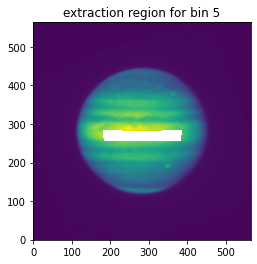

mu_0= 0.8749170851351167 mu_1= 1.1749170851351167


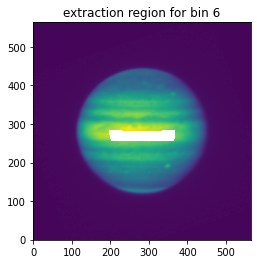

mu_0= 0.9374032659909695 mu_1= 1.2374032659909695


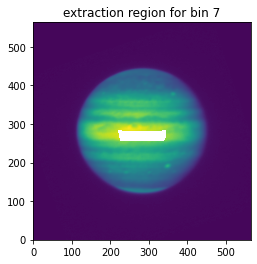

Extracting spectra for 2.16 nm...
mu_0= 0.5 mu_1= 0.8


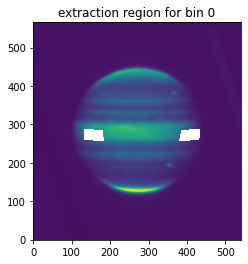

mu_0= 0.5624861808558528 mu_1= 0.8624861808558528


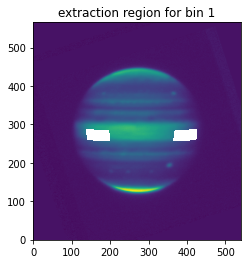

mu_0= 0.6249723617117056 mu_1= 0.9249723617117056


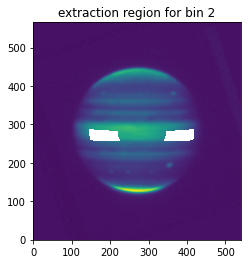

mu_0= 0.6874585425675583 mu_1= 0.9874585425675584


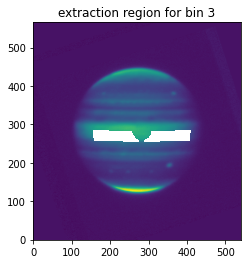

mu_0= 0.7499447234234111 mu_1= 1.0499447234234112


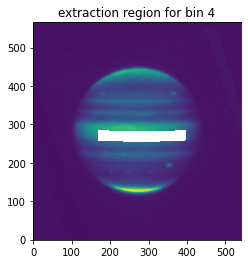

mu_0= 0.8124309042792639 mu_1= 1.112430904279264


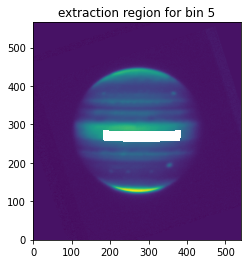

mu_0= 0.8749170851351167 mu_1= 1.1749170851351167


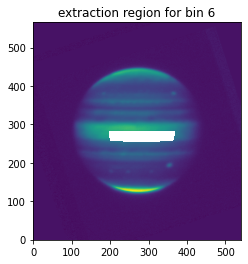

mu_0= 0.9374032659909695 mu_1= 1.2374032659909695


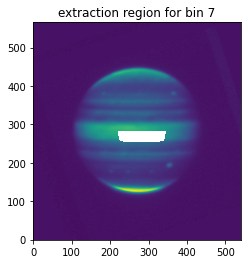

UnboundLocalError: local variable 'distance_au' referenced before assignment

In [19]:
extracted_spectrum_ave, extracted_lat_ave, extracted_long_ave, extracted_emiss_ave, extracted_solar_ave, extracted_azi_ave = spextraction_images('/Users/emmadahl/Desktop/spextraction/spextraction_input_binned_lat.txt','/Users/emmadahl/Desktop/spextraction/data_list_test.txt',map_load=1,plot_maps=1)

In [11]:
# !!! slice plot looks crazy small for some reason??
# !!! size/overlap of mu bins look a bit wonky. probably has to do with overlap or mu_1 going above 1?

In [12]:
# this should be a subroutine for spextraction

def spectrum_file_maker(input_list, file_format='Nemesis'):
    '''
    # !! need to make it so that text is saved to a file.
    # !! need to fix issue with ufloat not being isntalled
    # !! need to save distance seperately
    spx,lat,long,zen,szen,aphi
    format - string, label for desired format of spectrum file. currently only coded for Nemesis spx files.
    '''
    
    # pull spectra using spextraction_images
    extracted_spectrum_ave, extracted_lat_ave, extracted_long_ave, extracted_emiss_ave, extracted_solar_ave, extracted_azi_ave, wavelengths, distance_au, n_bins = spextraction_images('/Users/emmadahl/Desktop/spextraction/spextraction_input_binned_lat.txt','/Users/emmadahl/Desktop/spextraction/data_list_test.txt',map_save=1)
    
    # - - - - - - - - - - -
    
    if file_format == 'Nemesis':
    
        r = np.copy(distance_au) # AU. Need to average the distances from the images

        FWHM = 0
        LATITUDE = np.mean(extracted_lat_ave) # the average latitude of all spectra in the file
        LONGITUDE = np.mean(extracted_long_ave) # the average longitude of all spectra in the file
        NGEOM = np.copy(n_bins)
        NAV = 1

        # print overall header
        print('     ',FWHM,'  ', np.round(LATITUDE,3),'  ', np.round(LONGITUDE,3),'  ', NGEOM )

        # for spectra headers
        NCONV = len(wavelengths)
        NAV = 1

        for p in range(0,n_bins):
            
            # define header for that mu bin
            FLAT = np.mean(extracted_lat_ave[p,:])
            FLON = np.mean(extracted_long_ave[p,:])
            SOL_ANG = np.mean(extracted_solar_ave[p,:])
            EMISS_ANG = np.mean(extracted_emiss_ave[p,:])
            AZI_ANG = np.mean(extracted_azi_ave[p,:])
            WGEOM = '1'

            print( '     ',NCONV)
            print( '     ',NAV)
            print( '     ',np.round(FLAT,3),'  ',np.round(FLON,3),'  ',np.round(SOL_ANG,3),'  ',np.round(EMISS_ANG,3),'  ',np.round(AZI_ANG,3),'  ',WGEOM)

            # print spectrum
            for j in range(0,len(wavelengths)):
                # raw spectrum value*OPAL correction*IF factor*radiance conversion
                F_Solar = ufloat(F_S_corrwl[j],F_S_corrwl[j]*0.01)

                # !!! stand-in unit conversion, probably wrong.
                spectrum_value_with_error = ufloat(spec[p,:][j],np.sqrt(spec[p,:][j]))*1e-7*(1/0.0001)*((F_Solar*1e-22)/(r**2)/math.pi/1000) #1e-22 from difference between thullier solar spec files

                # print wavelength in microns, radiance, error:
                print( '     ',round(wavel_spxs[j],4), round(spectrum_value_with_error.nominal_value,12), round(spectrum_value_with_error.std_dev,12))

                # plot radiance spectra:
                #plt.plot(wavel_spxs[j],spectrum_value_with_error.nominal_value,'.')
            #plt.show()

In [ ]:
spectrum_file_maker('/Users/emmadahl/Desktop/spextraction/data_list_test.txt', file_format='Nemesis')

[1.64, 1.69, 2.16]
Arranging map info for 1.64
Loading image info and querying Horizons...
Generating maps...(ignore following errors, they are accounted for w/ iflag map)


/Users/emmadahl/opt/anaconda3/envs/pylanetary-tester/lib/python3.9/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in interceptellip (vectorized)
  outputs = ufunc(*inputs)
/var/folders/6_/b5j8td9x1658s508536j31jr0000gq/T/ipykernel_43371/3592222816.py:153: RuntimeWarning: invalid value encountered in scalar divide
  theta = np.arccos(z1/r)
/var/folders/6_/b5j8td9x1658s508536j31jr0000gq/T/ipykernel_43371/3592222816.py:178: RuntimeWarning: invalid value encountered in scalar divide
  v1[0] = x1/r
/var/folders/6_/b5j8td9x1658s508536j31jr0000gq/T/ipykernel_43371/3592222816.py:179: RuntimeWarning: invalid value encountered in scalar divide
  v1[1] = y1/r
/var/folders/6_/b5j8td9x1658s508536j31jr0000gq/T/ipykernel_43371/3592222816.py:180: RuntimeWarning: invalid value encountered in scalar divide
  v1[2] = z1/r


Saving maps at 1.64...
Arranging map info for 1.69
Loading image info and querying Horizons...
Generating maps...(ignore following errors, they are accounted for w/ iflag map)


/Users/emmadahl/opt/anaconda3/envs/pylanetary-tester/lib/python3.9/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in interceptellip (vectorized)
  outputs = ufunc(*inputs)
/var/folders/6_/b5j8td9x1658s508536j31jr0000gq/T/ipykernel_43371/3592222816.py:153: RuntimeWarning: invalid value encountered in scalar divide
  theta = np.arccos(z1/r)
/var/folders/6_/b5j8td9x1658s508536j31jr0000gq/T/ipykernel_43371/3592222816.py:178: RuntimeWarning: invalid value encountered in scalar divide
  v1[0] = x1/r
/var/folders/6_/b5j8td9x1658s508536j31jr0000gq/T/ipykernel_43371/3592222816.py:179: RuntimeWarning: invalid value encountered in scalar divide
  v1[1] = y1/r
/var/folders/6_/b5j8td9x1658s508536j31jr0000gq/T/ipykernel_43371/3592222816.py:180: RuntimeWarning: invalid value encountered in scalar divide
  v1[2] = z1/r


In [ ]:
# !! need to make distance finder seperate subroutine earlier so making maps isn't required every time